In [8]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt

eda_middle_data_path = 'eda-middle-data/'

res = pd.DataFrame([], columns=['pcode', 'max_amplitude', 'scr_count_per_minute'])
measurement = 'scr_count_per_minute'

for p_index in range(80):
    participant_key = 'P' + str(p_index + 1).zfill(2)
    file_path = eda_middle_data_path + participant_key + '_eda_result.csv'

    if not os.path.isfile(file_path):
        print(file_path + ' do not exist.')
        continue

    df = pd.read_csv(file_path)
    
    if len(df) < 5:
        print(file_path + ' has too less data, filtered out')
        continue
        
    res.loc[len(res)] = [participant_key, df['max_amplitude'].mean(), df['scr_count_per_minute'].mean()]

res

eda-middle-data/P01_eda_result.csv do not exist.
eda-middle-data/P04_eda_result.csv has too less data, filtered out
eda-middle-data/P08_eda_result.csv has too less data, filtered out
eda-middle-data/P27_eda_result.csv do not exist.
eda-middle-data/P29_eda_result.csv has too less data, filtered out
eda-middle-data/P48_eda_result.csv has too less data, filtered out
eda-middle-data/P49_eda_result.csv has too less data, filtered out
eda-middle-data/P59_eda_result.csv do not exist.
eda-middle-data/P65_eda_result.csv do not exist.
eda-middle-data/P73_eda_result.csv has too less data, filtered out
eda-middle-data/P74_eda_result.csv has too less data, filtered out
eda-middle-data/P75_eda_result.csv has too less data, filtered out
eda-middle-data/P76_eda_result.csv do not exist.


,pcode,max_amplitude,scr_count_per_minute
0,P02,0.000429,2.434815
1,P03,0.000202,3.980838
2,P05,0.000372,2.809771
3,P06,0.000461,3.458235
4,P07,0.000285,2.397431
...,...,...,...
62,P72,0.000167,2.476707
63,P77,0.000302,2.909111
64,P78,0.000195,2.553603
65,P79,0.002035,2.388313


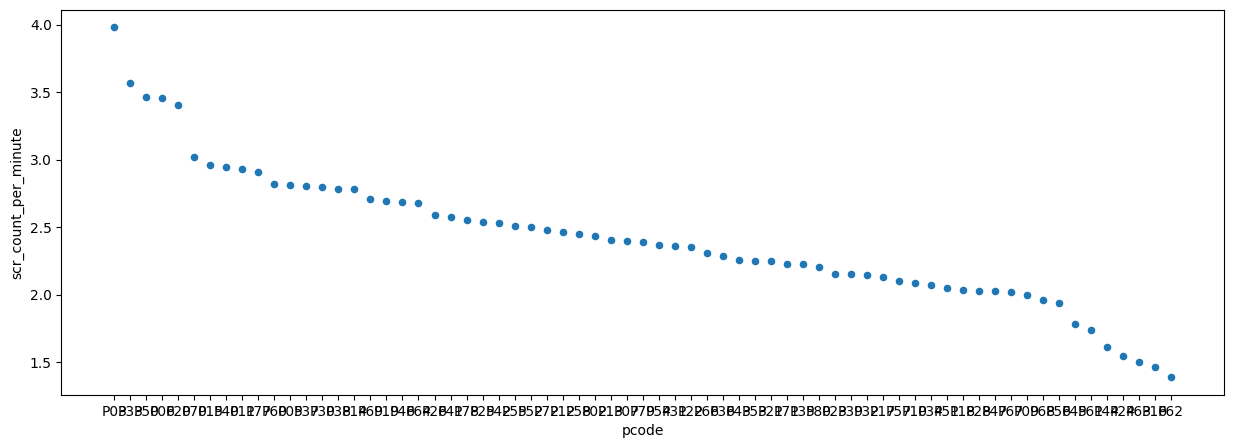

In [9]:
res.sort_values(by=measurement, ascending=False, inplace=True)
plot = res.plot(x='pcode', y=measurement, kind='scatter', figsize=(15, 5))

In [10]:
df_subj = pd.read_csv('dataset/SubjData/UserInfo.csv')
df_subj

,pcode,participationStartDate,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ
0,P01,2019-05-08,27,M,11,11,3,4,13,13,0,1
1,P02,2019-05-08,21,M,14,5,12,14,5,27,6,18
2,P03,2019-05-08,24,F,10,15,8,7,11,18,2,6
3,P04,2019-05-08,23,M,12,11,8,6,11,20,1,9
4,P05,2019-05-08,27,F,10,11,13,10,6,25,14,9
...,...,...,...,...,...,...,...,...,...,...,...,...
72,P76,2019-04-30,18,M,8,8,12,6,8,21,14,21
73,P77,2019-04-30,18,M,11,12,7,11,10,7,2,7
74,P78,2019-04-30,17,M,12,11,9,12,10,10,2,7
75,P79,2019-04-30,23,M,9,10,7,12,11,13,2,6


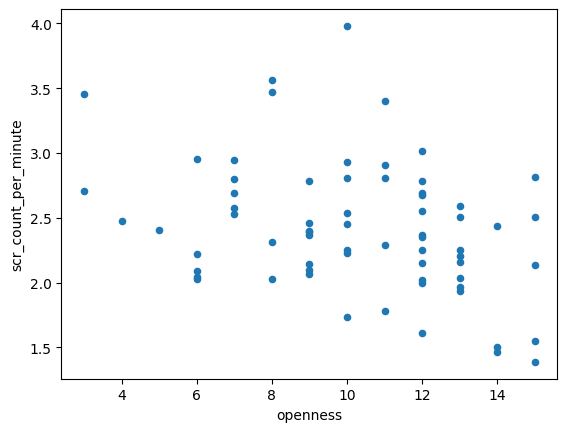

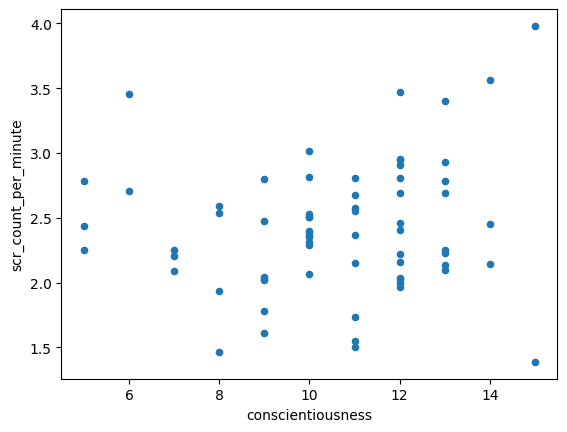

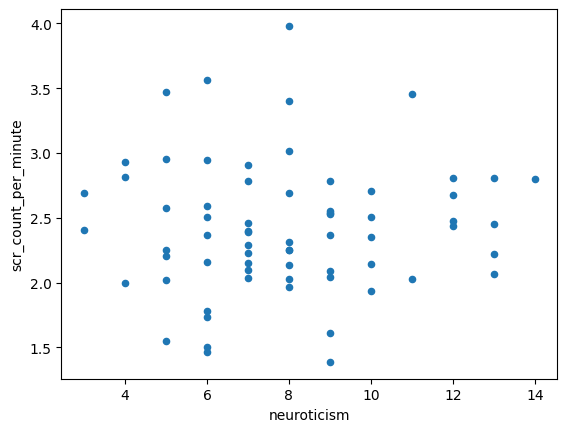

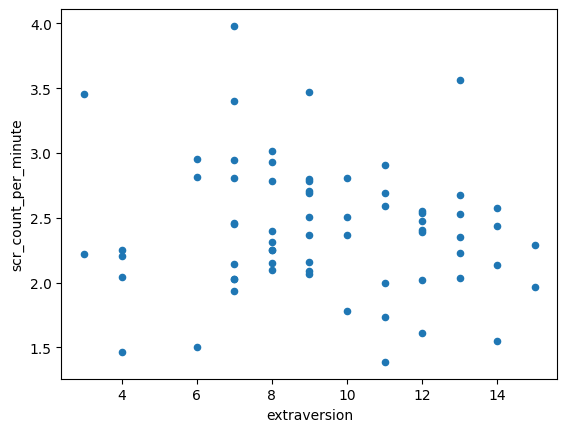

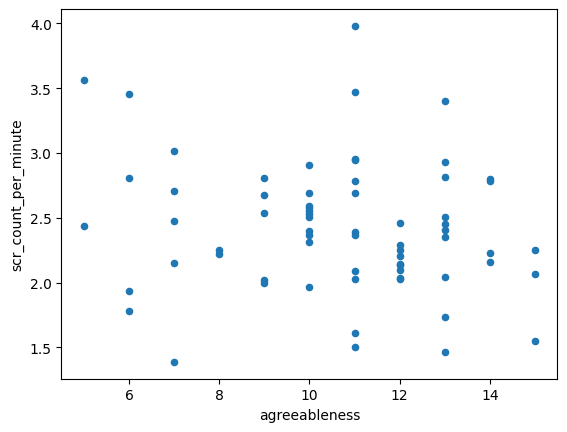

In [11]:
personality_traits = ['openness', 'conscientiousness', 'neuroticism', 'extraversion', 'agreeableness']
df_test = pd.merge(res, df_subj, on='pcode')

output_path = 'analyse_data/'
Path(output_path).mkdir(parents=True, exist_ok=True)

df_test.to_csv(f'{output_path}eda-results.csv', index=False)

for trait in personality_traits:
    df_test.plot(x=trait, y=measurement, kind='scatter')


In [12]:
import statsmodels.api as sm

X = df_test[personality_traits]
y = df_test[measurement]

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                             OLS Regression Results                             
Dep. Variable:     scr_count_per_minute   R-squared:                       0.186
Model:                              OLS   Adj. R-squared:                  0.119
Method:                   Least Squares   F-statistic:                     2.789
Date:                  Fri, 07 Jun 2024   Prob (F-statistic):             0.0247
Time:                          18:28:05   Log-Likelihood:                -42.183
No. Observations:                    67   AIC:                             96.37
Df Residuals:                        61   BIC:                             109.6
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             

ShapiroResult(statistic=0.992165687383806, pvalue=0.9514528020833743)

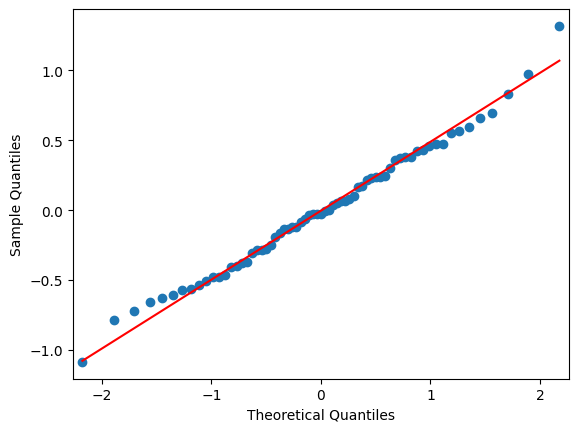

In [13]:
qq_plot = sm.qqplot(results.resid, line='q')
scipy.stats.shapiro(results.resid)

In [14]:
for trait in personality_traits:
    print(trait, scipy.stats.pearsonr(df_test[trait], df_test[measurement]))

openness PearsonRResult(statistic=-0.34312853504001795, pvalue=0.004474389938705962)
conscientiousness PearsonRResult(statistic=0.13253378389036813, pvalue=0.2850042495960603)
neuroticism PearsonRResult(statistic=0.042636995289111544, pvalue=0.7319092571560097)
extraversion PearsonRResult(statistic=-0.1125855990568104, pvalue=0.364354583971555)
agreeableness PearsonRResult(statistic=-0.16122857153757578, pvalue=0.1924302974460129)
